# Lab 5: Diffusion
Welcome to COMSM0159 Advanced Visual AI (AVAI)!

The goal of this labsheet is to provide an introduction to Diffusion Models based on the Week 5 lecture. By the end of this lab, you should be able to:
1. Understand the architecture of Diffusion Probabilistic Models (DDPMs)
2. Train a diffusion model on the MNIST datset to remove noise from images.
3. Experiment with the challenge: Enhancing the DDPM Model for the MNSIT Dataset.

### What is Diffusion Model?

A diffusion model is a generative model that progressively adds noise to data and then learns to reverse this process to recover the original data. It is often used for tasks like image generation, where it learns to generate clear images by reversing the noise-adding process step by step.

In [ ]:
# Load github resource in Colab
!git clone https://github.com/UoB-CS-AVAI/Week5-Diffusion.git
!mv Week5-Diffusion/* ./

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
import time  # For tracking time

# Set device
print(torch.__version__, torch.version.cuda, torch.cuda.is_available())
# For GPU (CUDA) or CPU
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Or for ARM-based MacOS
# device = torch.device('mps')  # Only applicable if running on a Mac with M1/M2 chip and PyTorch with MPS support

2.2.2+cu118 11.8 True


##### Model Hyperparameters
- **img_size**: `(28, 28, 1)`  
  The size of input images (height, width, channels). For MNIST, images are 28x28 pixels with a single channel (grayscale).
- **timestep_embedding_dim**: `256`  
  The dimensionality of the embeddings that represent the timesteps in the diffusion process.
- **n_layers**: `8`  
  The number of layers in the model, defining its depth.
- **n_timesteps**: `1000`  
  The number of timesteps in the diffusion process, representing the total steps for noise addition and denoising.
- **beta_minmax**: `[1e-4, 2e-2]`  
  Defines the range of noise scales (betas) used in the diffusion process, starting from `1e-4` to `2e-2`.

In [16]:
config = {
    'dataset': 'MNIST',
    'img_size': (28, 28, 1),
    'timestep_embedding_dim': 256,
    'n_layers': 8,
    'hidden_dim': 256,
    'n_timesteps': 1000,
    'beta_minmax': [1e-4, 2e-2],
    'train_batch_size': 128,
    'inference_batch_size': 64,
    'lr': 5e-5,
    'epochs': 10,
    'seed': 42,
}

In [17]:
hidden_dims = [config['hidden_dim'] for _ in range(config['n_layers'])]
torch.manual_seed(config['seed'])
# `config['seed']` to ensure that the initialization of weights and other random processes are consistent across different runs. This helps in making the training process reproducible.
np.random.seed(config['seed'])

### Step 1: Load Dataset and Create DataLoader
You will load the MNIST dataset and create DataLoaders for training and testing.
  - `train_dataset` loads the training data, and `test_dataset` loads the test data.
  - `transform`: Applies a transformation to convert images into tensors using `transforms.Compose([transforms.ToTensor()])`.
  - `kwargs`: Specifies additional settings like `num_workers=4` for parallel data loading and `pin_memory=True` for faster data transfer to GPU.

In [18]:
# Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
])

kwargs = {'num_workers': 4, 'pin_memory': True}
train_dataset = MNIST('./data/', transform=transform, train=True, download=True)
test_dataset = MNIST('./data/', transform=transform, train=False, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=config['train_batch_size'], shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=config['inference_batch_size'], shuffle=False, **kwargs)

### Step 2: Define our model: Denoising Diffusion Probabilistic Model (DDPM)
##### Sinusoidal embedding for diffusion timestep
  - `SinusoidalPosEmb(dim)`: Generates embeddings for time steps to help the model recognise the relative positions of each diffusion step.
  - `dim`: Specifies the dimension of the embedding.
  - `forward(x)`: Creates position-aware embeddings for a batch of time steps `x`.
    - Uses `sin` and `cos` functions to encode time information.
    - Helps the model understand how noise evolves over different time steps, aiding in effective denoising.
  - This sinusoidal positional embedding is crucial in the diffusion model as it encodes information about the position or timestep into a format that the model can use to better understand the temporal structure.

In [19]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

##### In this Lab, we use a simple stacked-convolution model with various dilations
  - `class ConvBlock(nn.Conv2d)`: A 2D convolutional block for diffusion models, supporting activation, dropout, and normalization.
  - `in_channels`, `out_channels`: Input and output channel sizes.
  - `kernel_size`, `stride`, `padding`, `dilation`: Control the convolution's spatial properties.
  - `forward(x, time_embedding=None, residual=False)`
    - Adds `time_embedding` if `residual=True` to incorporate timestep info.
  - This block helps the model adapt to different noise levels and time steps in the diffusion process.

You can also try building your own model: 

*Note: In the original paper, diffusion timestep embedding was only applied to residual blocks of U-Net.*

In [20]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """
    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        if residual:
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        return y

##### Define Denoiser
  - `class Denoiser(nn.Module)`: A model that removes noise from images at different steps of the diffusion process.
  - `image_resolution`: The size of input images `(H, W, C)`.
  - `self.time_embedding`: Generates embeddings for the diffusion timestep using `SinusoidalPosEmb`.

  - **`forward(perturbed_x, diffusion_timestep)`**:
    - `perturbed_x`: The noisy input image.
    - `diffusion_timestep`: The current time step of the noise removal process.
  - `Output`: Returns a denoised image of the same shape as `perturbed_x`.
  - This model leverages the time embeddings to adapt the denoising process at each timestep, effectively learning how to reduce noise as the diffusion process progresses.

In [21]:
class Denoiser(nn.Module):
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        _, _, img_C = image_resolution
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                                     
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)    
        
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2)) 
        y = self.in_project(y)
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True) 
        y = self.out_project(y)   
        return y

##### Define Gaussian Diffusion
- `class Diffusion(nn.Module)`: Handles the diffusion process, both adding noise and removing it to generate clean images.
- `n_times`: Number of diffusion steps.
- `betas`: Controls how much noise is added at each step.
- `alphas`: Derived from `betas`, used for noise removal.

    - `make_noisy(x_zeros, t)`: Adds noise to images at a given step `t`, simulating the forward process.
    - `forward(x_zeros)`: Adds noise to images and predicts the noise using the model.
    - `denoise_at_t(x_t, timestep)`: Uses the model to remove noise at a specific step.
    - `sample(N)`: Generates new images by starting with noise and denoising step-by-step.

  - This class models the forward and reverse processes of diffusion, adding noise progressively and then removing it to generate new images from pure noise.

In [22]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[28, 28, 1], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
        super(Diffusion, self).__init__()
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution
        self.model = model
        # Define linear variance schedule (betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper: cosine function instead of linear?
        self.sqrt_betas = torch.sqrt(betas)                             
        # Define alphas for forward diffusion process
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        self.device = device
    
    def extract(self, a, t, x_shape):
        # Extract the specific values for the batch of time-steps `t`
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    def scale_to_minus_one_to_one(self, x):
        # Scale input `x` from [0, 1] to [-1, 1]
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        # Scale input `x` from [-1, 1] back to [0, 1]
        return (x + 1) * 0.5
    
    def make_noisy(self, x_zeros, t): 
        # Perturb `x_0` into `x_t` (forward diffusion process)
        epsilon = torch.randn_like(x_zeros).to(self.device)
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
        return noisy_sample.detach(), epsilon
    
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        B, _, _, _ = x_zeros.shape
        # 1. Randomly select a diffusion time-step `t`
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        # 2. Forward diffusion: perturb `x_zeros` using the fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        # 3. Predict the noise (`epsilon`) given the perturbed image at time-step `t`
        pred_epsilon = self.model(perturbed_images, t)
        return perturbed_images, epsilon, pred_epsilon
    
    
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        # Generate random noise `z` for sampling, except for the final step (`t=0`)
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        # Use the model to predict noise (`epsilon_pred`) given `x_t` at `timestep`
        epsilon_pred = self.model(x_t, timestep)
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        # denoise at time t, denoise `x_t` to estimate `x_{t-1}`
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        return x_t_minus_1.clamp(-1., 1)
                
    def sample(self, N):
        # Start from random noise vector `x_T`, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        # Autoregressively denoise from `x_T` to `x_0`
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        # Convert the final result `x_0` back to [0, 1] range
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        return x_0

### Step 3: Initialise DDPM Model and optimizer
#### Task 1: Initialise DDPM Model and Optimizer
  - **`model`**: Creates a `Denoiser` using settings from `config` and moves it to `DEVICE`.
  - **`diffusion`**: Wraps the `model` to manage noise processes.
  - **`optimizer`**: Adam optimizer with learning rate from .
  - This setup gets the model ready for training.

In [23]:
# TODO: Initialise Model and optimizer
model = Denoiser(image_resolution=config['img_size'],
                 hidden_dims=hidden_dims,
                 diffusion_time_embedding_dim=config['timestep_embedding_dim'],
                 n_times=config['n_timesteps']).to(DEVICE)

diffusion = Diffusion(model, image_resolution=config['img_size'], n_times=config['n_timesteps'],
                      beta_minmax=config['beta_minmax'], device=DEVICE).to(DEVICE)

optimizer = optim.Adam(diffusion.parameters(), lr=config['lr'])

#### Task 2: Visualising forward process

- Display a specific image (idx) from a batch (x) to visually assess how the noise affects it at a given timestep.
- TODO: Generate and display images at different timesteps to show how noise progressively increases during the diffusion process.

In [24]:
# Displays the image at `idx` from batch `x`
def show_image(x, idx):
    fig = plt.figure()
    image_data = x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy()
    image_data = np.clip(image_data, 0, 1)
    plt.imshow(image_data)

In [25]:
# TODO: Generate and display images at different timesteps
def visualise_forward_process_by_t(diffusion, x, num_timesteps_to_show):
    x = diffusion.scale_to_minus_one_to_one(x)
    timesteps = torch.linspace(0, diffusion.n_times - 1, steps=num_timesteps_to_show).long().to(diffusion.device)
    fig, axs = plt.subplots(1, num_timesteps_to_show, figsize=(20, 4))
    for idx, t in enumerate(timesteps):
        t = t.unsqueeze(0)
        perturbed_images, _ = diffusion.make_noisy(x, t)
        axs[idx].imshow(diffusion.reverse_scale_to_zero_to_one(perturbed_images)[0, 0].cpu().numpy())
        axs[idx].axis('off')
        axs[idx].set_title(f't={t.item()}')
    plt.show()

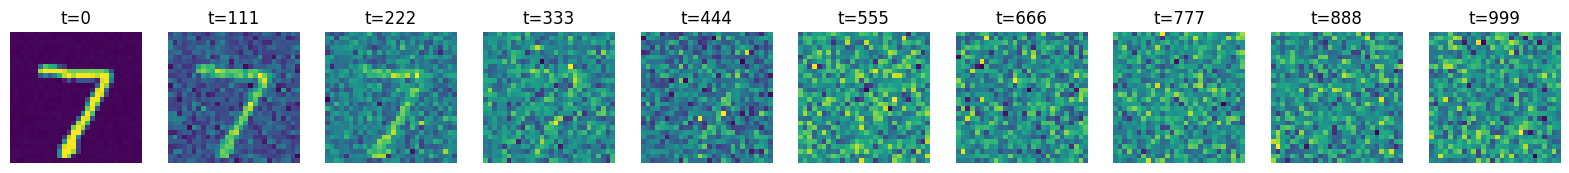

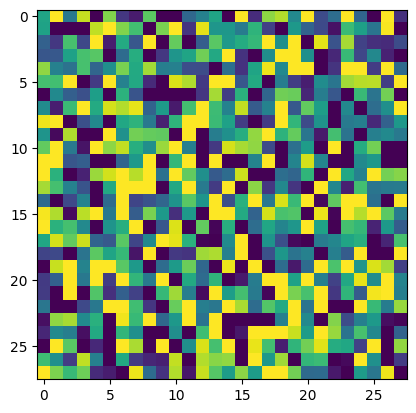

In [26]:
model.eval()  # Set model to evaluation mode
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    # TODO: Generate and display images at different timesteps
    visualise_forward_process_by_t(diffusion, x, num_timesteps_to_show=10)
    break

# Show the perturbed image
show_image(perturbed_images, idx=0)

### Step 4: Define the Train Loop - Train Denoising Diffusion Probabilistic Models (DDPMs)
#### Task 3: Train the diffusion model using MNIST data
- `diffusion.train()`: Set the model to training mode.
- `denoising_loss`: Uses Mean Squared Error (MSE) loss to measure the difference between the predicted and actual noise.
- **Training Loop**: For each batch
    - Adds noise to images.
    - Predicts noise and computes the loss.
    - Updates model parameters using `optimizer`.
    - Displays the average loss.
- `noisy_input, epsilon, pred_epsilon = diffusion(x)`: Generates noisy images and predicts the noise.
- `loss = denoising_loss(pred_epsilon, epsilon)`: Calculates the loss between the predicted noise and true noise.

#### Task 4: Measure and compare the training time with the inference time of the model, then analyse and discuss the results.

In [27]:
def train(diffusion, train_loader, optimizer, epochs, device):
    # TODO: Set model to train mode
    diffusion.train()
    
    # Initialise gradient scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    # TODO: Define loss function (Mean Squared Error Loss)
    denoising_loss = nn.MSELoss()

    total_train_time = 0
    for epoch in range(epochs):
        epoch_start_time = time.time()
        total_loss = 0.0
        for batch_idx, (x, _) in enumerate(train_loader):
            # Clear previous gradients
            optimizer.zero_grad()
            x = x.to(device)
            # Forward pass with mixed precision
            # - **Mixed Precision**: `torch.cuda.amp.autocast()` enables faster training with less memory usage.
            with torch.cuda.amp.autocast():
                # TODO: Call the diffusion model to get noisy input
                noisy_input, epsilon, pred_epsilon = diffusion(x)
                # TODO: Calculate the denoising loss
                loss = denoising_loss(pred_epsilon, epsilon)
            
            # Use the scaler to scale the loss and backpropagate
            scaler.scale(loss).backward()
            
            # TODO: Update the model parameters using the optimizer
            scaler.step(optimizer)
            # TODO: Update the scaler for the next iteration
            scaler.update()
            
            # TODO: Accumulate the loss
            total_loss += loss.item()

        # TODO: Print the average loss for this epoch
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")
        # TODO: Print the training time for this epoch
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        total_train_time += epoch_duration
        print(f"Epoch {epoch + 1} time: {epoch_end_time - epoch_start_time:.2f} seconds")
    print("Training finished!")
    print(f"Total training time: {total_train_time:.2f} seconds")

In [28]:
# TODO: Training - Try more epochs and see what happens
print("Start training DDPMs...")
train(diffusion, train_loader, optimizer, config['epochs'], DEVICE)

Start training DDPMs...
Epoch [1/10], Loss: 0.085892
Epoch 1 time: 42.17 seconds
Epoch [2/10], Loss: 0.038040
Epoch 2 time: 41.86 seconds
Epoch [3/10], Loss: 0.034002
Epoch 3 time: 42.12 seconds
Epoch [4/10], Loss: 0.032249
Epoch 4 time: 41.47 seconds
Epoch [5/10], Loss: 0.030607
Epoch 5 time: 41.11 seconds
Epoch [6/10], Loss: 0.029856
Epoch 6 time: 40.90 seconds
Epoch [7/10], Loss: 0.028978
Epoch 7 time: 41.05 seconds
Epoch [8/10], Loss: 0.028635
Epoch 8 time: 40.83 seconds
Epoch [9/10], Loss: 0.028074
Epoch 9 time: 41.51 seconds
Epoch [10/10], Loss: 0.027759
Epoch 10 time: 41.70 seconds
Training finished!
Total training time: 414.72 seconds


### Step 5: Sample images from noise.

In [29]:
def draw_sample_image(x, postfix):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Visualisation of {postfix}")
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

#### Task 5: Evaluation and Sampling

Inference time: 29.11 seconds


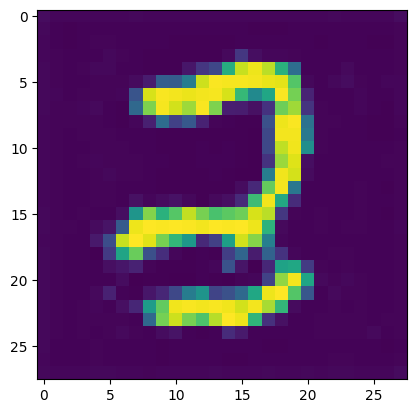

In [30]:
# TODO: Evaluation and Sampling
model.eval()  # Set model to evaluation mode
# TODO: Measure inference time
inference_start_time = time.time()
with torch.no_grad():
    # Generate a batch of images
    generated_images = diffusion.sample(N=config['inference_batch_size'])
inference_end_time = time.time()
inference_time = inference_end_time - inference_start_time
print(f"Inference time: {inference_time:.2f} seconds")
show_image(generated_images, idx=0)

#### Task 6: Comparison with ground-truth samples

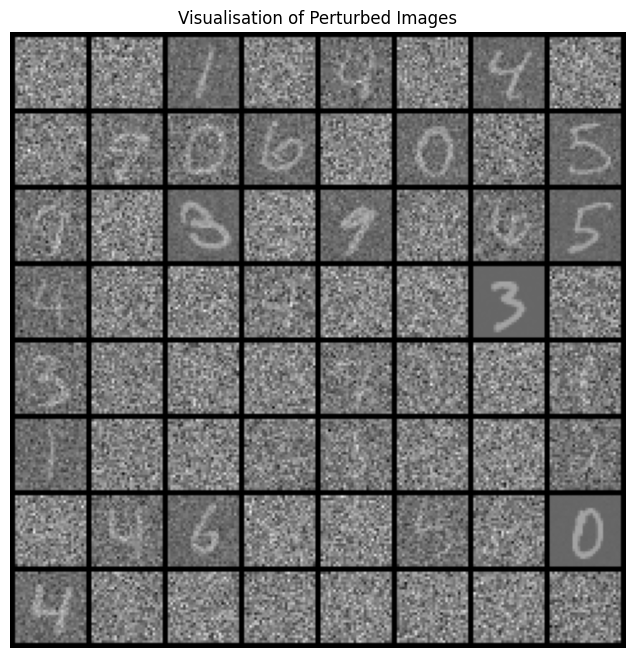

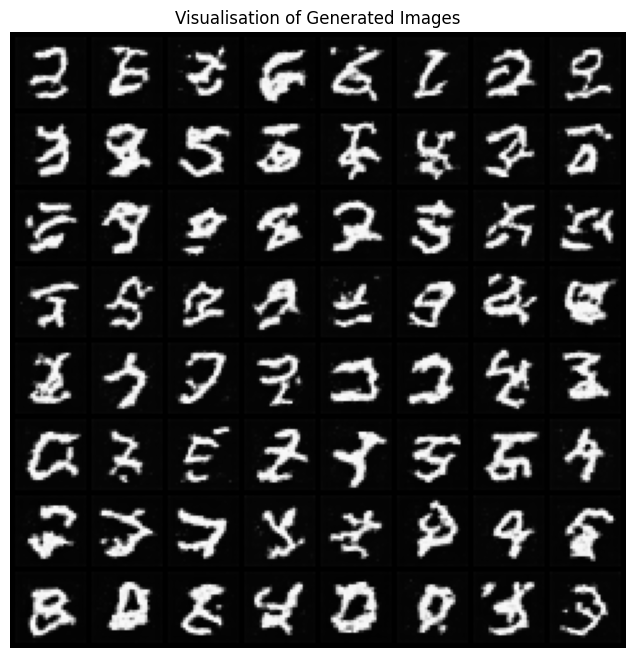

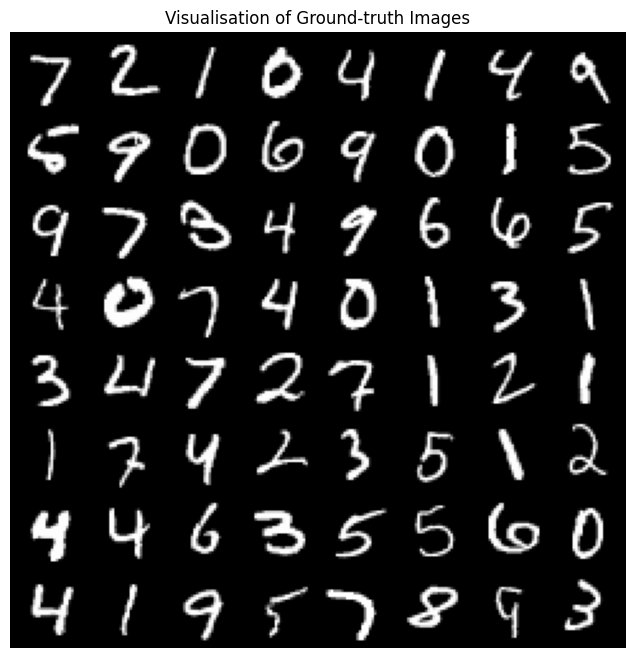

In [31]:
# TODO: Visualisation
draw_sample_image(perturbed_images, "Perturbed Images")  # Display a sample of noisy images
draw_sample_image(generated_images, "Generated Images")  # Display images generated by the model
draw_sample_image(next(iter(test_loader))[0][:config['inference_batch_size']], "Ground-truth Images")  # Display a sample of original images
plt.show()

### Challenge: Enhancing the DDPM Model for the MNSIT Dataset

- Use the same network structure. You need to experiment with different parameters and loss functions to optimise the performance of the model.

#### Task 1: Parameter Tuning
- Training epochs: Change the number of training epochs that the model needs to efficiently learn the diffusion process.

- Timesteps: Try using different timesteps in the diffusion process to see how they affect the quality of the noised image and denoised images.

- Beta schedule: Modify the beta values used in the diffusion process to improve image generation.

#### Task 2: Add noise using a cosine schedule instead of a linear schedule 
- Reference: https://arxiv.org/abs/2102.09672

#### Task 3: Loss Functions
- Explore alternatives to MSE: e.g. MAE, SSIM, LPIPS.
- SSIM better captures perceptual and structural similarities in images. Test in combination with different losses.

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from model.Denoiser import Denoiser
from model.utils import show_image, draw_sample_image, visualise_forward_process_by_t


class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[28, 28, 1], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
        super(Diffusion, self).__init__()
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution
        self.model = model
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device)
        self.sqrt_betas = torch.sqrt(betas)
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        self.device = device

    def extract(self, a, t, x_shape):
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x):
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t):
        epsilon = torch.randn_like(x_zeros).to(self.device)
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
        return noisy_sample.detach(), epsilon

    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        B, _, _, _ = x_zeros.shape
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        pred_epsilon = self.model(perturbed_images, t)
        return perturbed_images, epsilon, pred_epsilon

    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        epsilon_pred = self.model(x_t, timestep)
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1 - alpha) / sqrt_one_minus_alpha_bar * epsilon_pred) + sqrt_beta * z
        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N):
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        for t in range(self.n_times - 1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        return x_0